In [1]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils import data
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from torchvision.datasets import ImageFolder
from transformers import ViTConfig, ViTForImageClassification
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, roc_auc_score
import gc
import pandas as pd

c:\Users\The Nameless One\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
augment_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.RandomHorizontalFlip(1.0),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2), antialias=True),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
    transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [3]:
path = "Dataset"
train_dataset = ImageFolder(path+"/train", transform=transform)
augment_dataset = ImageFolder(path+"/train", transform=augment_transform)
train_dataset = ConcatDataset([train_dataset, augment_dataset])
test_dataset = ImageFolder(path+"/test", transform=transform)

In [4]:
print(len(train_dataset))
print(len(test_dataset))

57418
7178


In [5]:
training_ratio = 0.9
n_train_examples = int(len(train_dataset) * training_ratio)
n_valid_examples = len(train_dataset) - n_train_examples
train_data, valid_data = data.random_split(train_dataset, [n_train_examples, n_valid_examples])
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = transform

In [6]:
def collate_function(dataset):
    images = []
    labels = []
    for image, label in dataset:
        images.append(image)
        labels.append(label)

    pixel_values = torch.stack(images)
    labels = torch.tensor(labels)
    return {"pixel_values": pixel_values, "labels": labels}

Batch_Size = 64
train_loader = DataLoader(train_dataset, collate_fn=collate_function, batch_size=Batch_Size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_data, collate_fn=collate_function, batch_size=Batch_Size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, collate_fn=collate_function, batch_size=Batch_Size, shuffle=False, num_workers=0)

In [7]:
def print_data(loader):
    for i, batch in enumerate(loader):
        print(f"Batch {i+1}:")
        print("Pixel values:")
        print(batch["pixel_values"])
        print("Labels:")
        print(batch["labels"])
        break

print("Train loader:")
print_data(train_loader)

print("Valid loader:")
print_data(valid_loader)

print("Test loader:")
print_data(test_loader)


Train loader:
Batch 1:
Pixel values:
tensor([[[[-0.1686, -0.1686, -0.1765,  ..., -0.0513, -0.0510, -0.0510],
          [-0.1686, -0.1686, -0.1765,  ..., -0.0513, -0.0510, -0.0510],
          [-0.1717, -0.1717, -0.1795,  ..., -0.0538, -0.0535, -0.0535],
          ...,
          [ 0.4765,  0.4765,  0.4765,  ..., -0.4761, -0.4762, -0.4762],
          [ 0.4745,  0.4745,  0.4745,  ..., -0.4821, -0.4824, -0.4824],
          [ 0.4745,  0.4745,  0.4745,  ..., -0.4821, -0.4824, -0.4824]],

         [[-0.1686, -0.1686, -0.1765,  ..., -0.0513, -0.0510, -0.0510],
          [-0.1686, -0.1686, -0.1765,  ..., -0.0513, -0.0510, -0.0510],
          [-0.1717, -0.1717, -0.1795,  ..., -0.0538, -0.0535, -0.0535],
          ...,
          [ 0.4765,  0.4765,  0.4765,  ..., -0.4761, -0.4762, -0.4762],
          [ 0.4745,  0.4745,  0.4745,  ..., -0.4821, -0.4824, -0.4824],
          [ 0.4745,  0.4745,  0.4745,  ..., -0.4821, -0.4824, -0.4824]],

         [[-0.1686, -0.1686, -0.1765,  ..., -0.0513, -0.0510, -0.

In [8]:
device = torch.device("cuda")

In [9]:
torch.cuda.empty_cache()
gc.collect()

60

In [10]:
configuration = ViTConfig()
configuration.num_labels = 7
configuration.return_dict = False

In [11]:
model = ViTForImageClassification(configuration).from_pretrained('google/vit-base-patch16-224')
model.num_labels = 7
model.name = 'Vision Transformer'
model.classifier = nn.Linear(configuration.hidden_size, configuration.num_labels)
vit = model.to(device)

for param in vit.vit.parameters():
    param.requires_grad = False
for param in vit.classifier.parameters():
    param.requires_grad = True
for param in vit.vit.encoder.layer[-1].parameters():
    param.requires_grad = True
for param in vit.vit.layernorm.parameters():
    param.requires_grad = True

In [12]:
for name, param in vit.named_parameters():
     print(name, param.requires_grad)

vit.embeddings.cls_token False
vit.embeddings.position_embeddings False
vit.embeddings.patch_embeddings.projection.weight False
vit.embeddings.patch_embeddings.projection.bias False
vit.encoder.layer.0.attention.attention.query.weight False
vit.encoder.layer.0.attention.attention.query.bias False
vit.encoder.layer.0.attention.attention.key.weight False
vit.encoder.layer.0.attention.attention.key.bias False
vit.encoder.layer.0.attention.attention.value.weight False
vit.encoder.layer.0.attention.attention.value.bias False
vit.encoder.layer.0.attention.output.dense.weight False
vit.encoder.layer.0.attention.output.dense.bias False
vit.encoder.layer.0.intermediate.dense.weight False
vit.encoder.layer.0.intermediate.dense.bias False
vit.encoder.layer.0.output.dense.weight False
vit.encoder.layer.0.output.dense.bias False
vit.encoder.layer.0.layernorm_before.weight False
vit.encoder.layer.0.layernorm_before.bias False
vit.encoder.layer.0.layernorm_after.weight False
vit.encoder.layer.0.layer

In [13]:
model_parameters = filter(lambda p: p.requires_grad, vit.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

7094791

In [14]:
In_testing = False
optimizer = optim.Adam(vit.parameters(), lr = 0.001)
num_epochs = 30
num_training_steps = num_epochs * len(train_loader)

In [15]:
from collections import Counter

def counter(list):

    counter = Counter(list)
    value_list = []
    prev_i = 0
    for i in counter.values():
        sub_list = list[prev_i:i+prev_i]
        prev_i += i
        value_list.append(sub_list)
    return value_list


In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

def plot_roc_auc(y_true, y_preds):

    y_true = counter(y_true)
    y_preds = counter(y_preds)

    class_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
    classes = list(range(7))
    y_true_bin = label_binarize(np.concatenate(y_true), classes=classes)
    y_pred_bin = label_binarize(np.concatenate(y_preds), classes=classes)

    roc_auc = dict()
    fpr = dict()
    tpr = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[classes[i]] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown']
    for i, color in zip(range(len(classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(class_labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic to Multi-Class')
    plt.legend(loc="lower right")
    plt.show()



In [25]:
def plot_confusion_matrix(cm, class_labels=["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]):
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

    plt.figure(figsize=(18,12))
    sns.heatmap(cm_df, annot=True, fmt='.2%', cmap='Blues')

    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    plt.show()

In [18]:
def compute_and_plot_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [accuracy, precision, recall, f1]

    plt.plot(metrics, values, marker='o')
    plt.ylim([0, 1])
    plt.title(f'Model Metrics')
    plt.show()

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    report = classification_report(y_true, y_pred)
    print(report)

In [19]:
from tqdm import tqdm
def ViT_test(model, dataloader):
    model.eval()

    correct = 0
    total_loss = 0
    total = 0
    all_labels = []
    all_predictions = []

    for batch in tqdm(dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        total_loss += outputs[0]
        logits = outputs[1]
        predictions = torch.argmax(logits, dim=-1)
        total += batch['labels'].size(0)
        correct += (predictions == batch['labels']).sum().item()
        all_labels.extend(batch['labels'].cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

    acc = 100 * correct / total
    total_loss = total_loss / total
    
    
    if In_testing == True:
        cm = confusion_matrix(all_labels, all_predictions)
        plot_confusion_matrix(cm)
        compute_and_plot_metrics(all_labels, all_predictions)
        plot_roc_auc(all_labels, all_predictions)

    return acc, total_loss

In [20]:
def save_checkpoint(model, optimizer, epoch, train_accs, valid_accs, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_accs': train_accs,
        'valid_accs': valid_accs
    }
    torch.save(checkpoint, filename)

In [21]:
def load_checkpoint(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])       #?
    return checkpoint['epoch'], checkpoint['train_accs'], checkpoint['valid_accs']

In [22]:
def ViT_train(model, optimizer, start_epoch=0, train_accs=[], valid_accs=[]):
    model.train()

    for epoch in range(start_epoch, num_epochs):
        train_loss = 0
        train_correct = 0
        total = 0
        train_predictions = []
        train_labels = []
        for batch in tqdm(train_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs[0]
            loss.backward()

            train_loss += loss.item()
            logits = outputs[1]
            predictions = torch.argmax(logits, dim=-1)
            total += batch['labels'].size(0)
            train_correct += (predictions == batch['labels']).sum().item()

            train_predictions.append(predictions.detach().cpu())
            train_labels.append(batch['labels'].detach().cpu())

            optimizer.step()
            optimizer.zero_grad()

        train_loss = train_loss / total
        train_acc = 100 * train_correct / total
        print("Epoch {}".format(epoch+1))
        print("Train loss: {}.\t Train accuracy: {:.2f}%".format(train_loss, train_acc))

        train_accs.append(train_acc)

        train_predictions = torch.cat(train_predictions)
        train_labels = torch.cat(train_labels)

        compute_and_plot_metrics(train_labels, train_predictions)

        valid_acc, valid_loss = ViT_test(model, valid_loader)
        print("Valid loss: {}.\t Valid accuracy: {:.2f}%".format(valid_loss, valid_acc))

        valid_accs.append(valid_acc)

        torch.save(model, "model.pth")
        save_checkpoint(model, optimizer, epoch, train_accs, valid_accs, "checkpoint.pth")

    plt.plot(train_accs, label='Train Accuracy', color='blue')
    plt.plot(valid_accs, label='Valid Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
ViT_train(model, optimizer)

100%|██████████| 898/898 [59:20<00:00,  3.97s/it]


Epoch 2
Train loss: 0.012854494266825753.	 Train accuracy: 69.36%


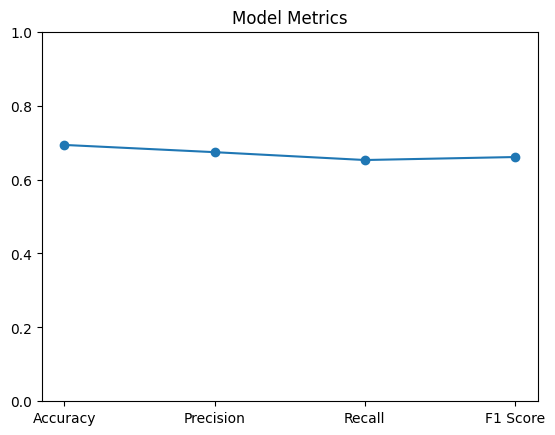

Accuracy: 0.6935804103242885
Precision: 0.6740041897672675
Recall: 0.6527532573761489
F1 Score: 0.6608506704325589
              precision    recall  f1-score   support

           0       0.62      0.59      0.61      7990
           1       0.65      0.50      0.57       872
           2       0.59      0.48      0.53      8194
           3       0.86      0.88      0.87     14430
           4       0.65      0.72      0.68      9930
           5       0.58      0.61      0.60      9660
           6       0.77      0.79      0.78      6342

    accuracy                           0.69     57418
   macro avg       0.67      0.65      0.66     57418
weighted avg       0.69      0.69      0.69     57418



100%|██████████| 90/90 [18:40<00:00, 12.45s/it]


Valid loss: 0.012149583548307419.	 Valid accuracy: 71.65%


100%|██████████| 898/898 [1:20:12<00:00,  5.36s/it]  

Epoch 3
Train loss: 0.012170774678234903.	 Train accuracy: 71.04%


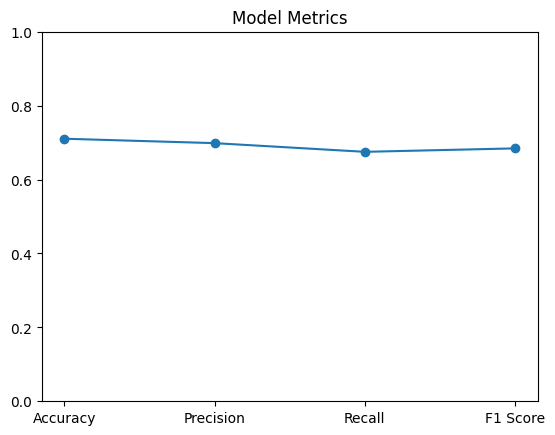

Accuracy: 0.7103869866592358
Precision: 0.6984179068213212
Recall: 0.6749268224047426
F1 Score: 0.684253608737243
              precision    recall  f1-score   support

           0       0.65      0.62      0.63      7990
           1       0.71      0.55      0.62       872
           2       0.61      0.51      0.56      8194
           3       0.86      0.89      0.87     14430
           4       0.66      0.73      0.69      9930
           5       0.60      0.63      0.62      9660
           6       0.79      0.80      0.80      6342

    accuracy                           0.71     57418
   macro avg       0.70      0.67      0.68     57418
weighted avg       0.71      0.71      0.71     57418



100%|██████████| 90/90 [04:15<00:00,  2.84s/it]


Valid loss: 0.010944444686174393.	 Valid accuracy: 73.30%


100%|██████████| 898/898 [47:02<00:00,  3.14s/it]

Epoch 4
Train loss: 0.01136281951940638.	 Train accuracy: 72.91%


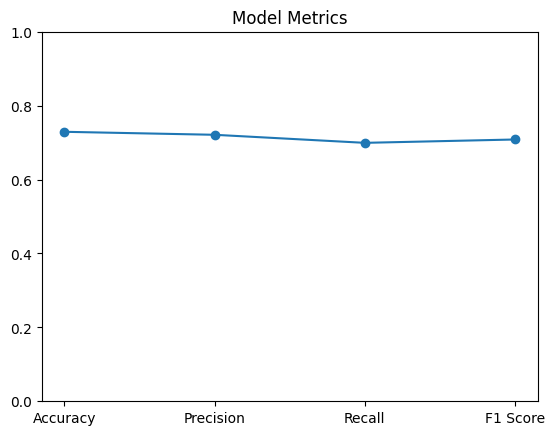

Accuracy: 0.7291267546762339
Precision: 0.7210130359580719
Recall: 0.6992328059255167
F1 Score: 0.7083146812964131
              precision    recall  f1-score   support

           0       0.67      0.64      0.66      7990
           1       0.75      0.61      0.67       872
           2       0.64      0.55      0.59      8194
           3       0.87      0.90      0.88     14430
           4       0.68      0.74      0.71      9930
           5       0.62      0.65      0.64      9660
           6       0.80      0.81      0.81      6342

    accuracy                           0.73     57418
   macro avg       0.72      0.70      0.71     57418
weighted avg       0.73      0.73      0.73     57418



100%|██████████| 90/90 [04:15<00:00,  2.84s/it]


Valid loss: 0.010230963118374348.	 Valid accuracy: 76.00%


100%|██████████| 898/898 [46:59<00:00,  3.14s/it]

Epoch 5
Train loss: 0.010644838855455835.	 Train accuracy: 74.64%


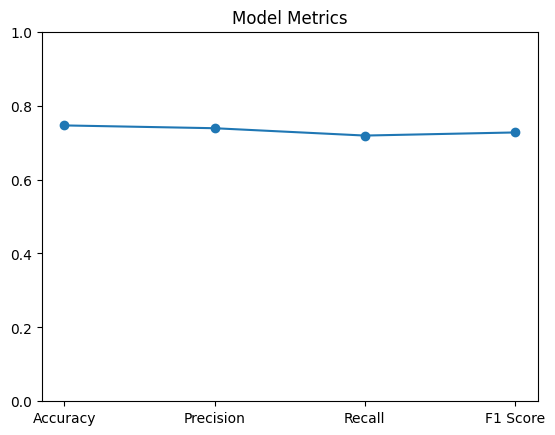

Accuracy: 0.7463687345431747
Precision: 0.7387947822867963
Recall: 0.7189356760088366
F1 Score: 0.7273604566102563
              precision    recall  f1-score   support

           0       0.70      0.66      0.68      7990
           1       0.77      0.64      0.70       872
           2       0.66      0.58      0.61      8194
           3       0.88      0.90      0.89     14430
           4       0.70      0.76      0.73      9930
           5       0.65      0.67      0.66      9660
           6       0.82      0.82      0.82      6342

    accuracy                           0.75     57418
   macro avg       0.74      0.72      0.73     57418
weighted avg       0.74      0.75      0.74     57418



100%|██████████| 90/90 [04:15<00:00,  2.84s/it]


Valid loss: 0.00936884991824627.	 Valid accuracy: 77.85%


100%|██████████| 898/898 [47:02<00:00,  3.14s/it]

Epoch 6
Train loss: 0.010047157330570137.	 Train accuracy: 76.06%


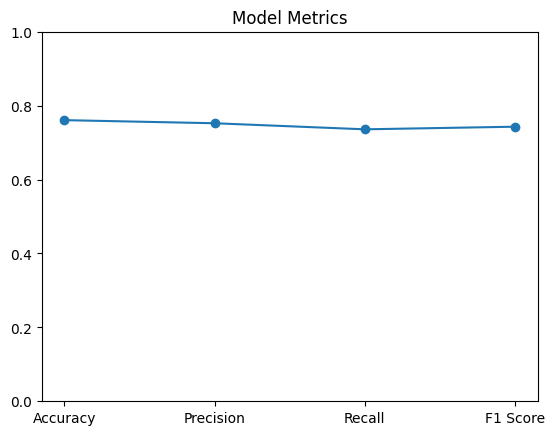

Accuracy: 0.7606325542512801
Precision: 0.7522495597179593
Recall: 0.7358164106613939
F1 Score: 0.7428939719058067
              precision    recall  f1-score   support

           0       0.71      0.68      0.70      7990
           1       0.77      0.67      0.71       872
           2       0.68      0.60      0.64      8194
           3       0.89      0.91      0.90     14430
           4       0.72      0.77      0.75      9930
           5       0.67      0.69      0.68      9660
           6       0.83      0.83      0.83      6342

    accuracy                           0.76     57418
   macro avg       0.75      0.74      0.74     57418
weighted avg       0.76      0.76      0.76     57418



100%|██████████| 90/90 [04:15<00:00,  2.84s/it]


Valid loss: 0.009108091704547405.	 Valid accuracy: 78.58%


100%|██████████| 898/898 [47:02<00:00,  3.14s/it]

Epoch 7
Train loss: 0.009460423814006358.	 Train accuracy: 77.40%


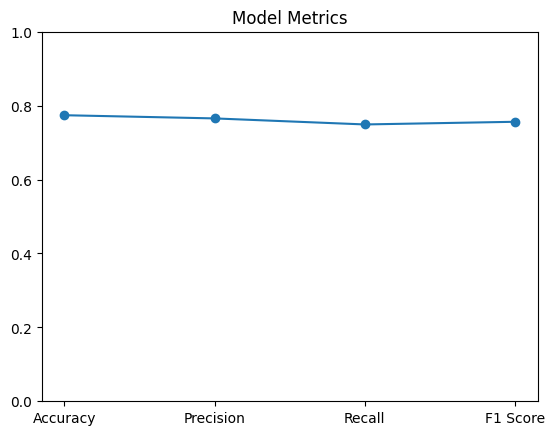

Accuracy: 0.7739733184715595
Precision: 0.7653434907577026
Recall: 0.748993573904891
F1 Score: 0.7562251930144052
              precision    recall  f1-score   support

           0       0.73      0.70      0.72      7990
           1       0.78      0.67      0.72       872
           2       0.70      0.63      0.66      8194
           3       0.89      0.91      0.90     14430
           4       0.74      0.77      0.76      9930
           5       0.68      0.71      0.70      9660
           6       0.84      0.85      0.84      6342

    accuracy                           0.77     57418
   macro avg       0.77      0.75      0.76     57418
weighted avg       0.77      0.77      0.77     57418



100%|██████████| 90/90 [04:15<00:00,  2.84s/it]


Valid loss: 0.00808359682559967.	 Valid accuracy: 80.74%


100%|██████████| 898/898 [47:01<00:00,  3.14s/it]

Epoch 8
Train loss: 0.008948537843421466.	 Train accuracy: 78.70%


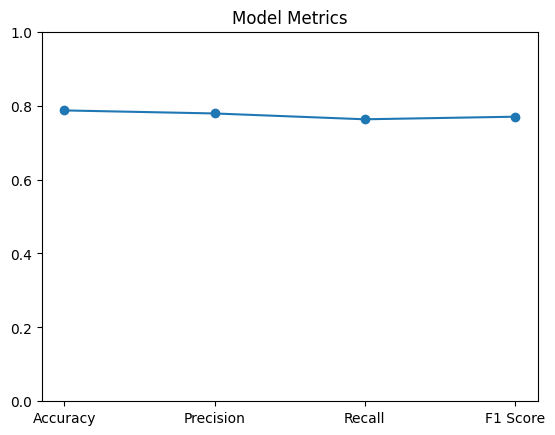

Accuracy: 0.7869657598662441
Precision: 0.7787224077252921
Recall: 0.7629556117942771
F1 Score: 0.7699748310938451
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      7990
           1       0.79      0.69      0.73       872
           2       0.72      0.65      0.68      8194
           3       0.90      0.92      0.91     14430
           4       0.75      0.79      0.77      9930
           5       0.71      0.73      0.72      9660
           6       0.85      0.85      0.85      6342

    accuracy                           0.79     57418
   macro avg       0.78      0.76      0.77     57418
weighted avg       0.79      0.79      0.79     57418



100%|██████████| 90/90 [04:04<00:00,  2.72s/it]


Valid loss: 0.008147528395056725.	 Valid accuracy: 80.86%


100%|██████████| 898/898 [47:07<00:00,  3.15s/it]


Epoch 9
Train loss: 0.008451000804802962.	 Train accuracy: 79.87%


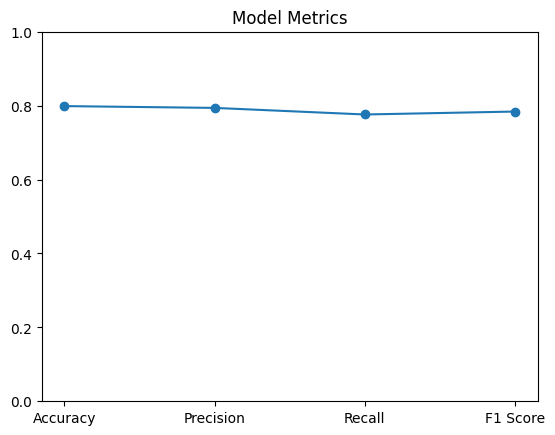

Accuracy: 0.7986519906649483
Precision: 0.7937582028525617
Recall: 0.7759459147859644
F1 Score: 0.7839212861888853
              precision    recall  f1-score   support

           0       0.76      0.73      0.74      7990
           1       0.82      0.70      0.76       872
           2       0.73      0.68      0.70      8194
           3       0.90      0.92      0.91     14430
           4       0.77      0.80      0.79      9930
           5       0.72      0.74      0.73      9660
           6       0.85      0.85      0.85      6342

    accuracy                           0.80     57418
   macro avg       0.79      0.78      0.78     57418
weighted avg       0.80      0.80      0.80     57418



100%|██████████| 90/90 [04:15<00:00,  2.84s/it]


Valid loss: 0.007424929179251194.	 Valid accuracy: 82.71%


100%|██████████| 898/898 [47:03<00:00,  3.14s/it]

Epoch 10
Train loss: 0.008076326666148945.	 Train accuracy: 80.82%


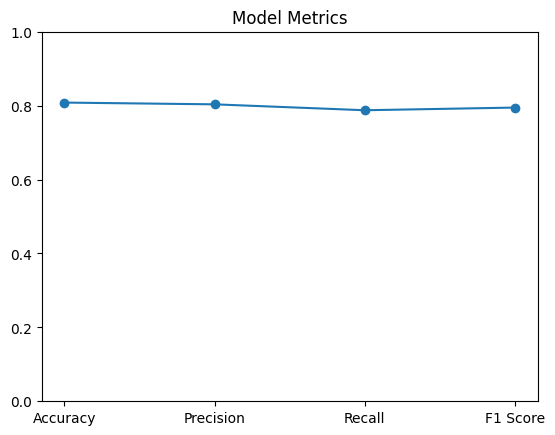

Accuracy: 0.808178619944965
Precision: 0.8034141341591248
Recall: 0.7874413563847048
F1 Score: 0.7946676939912592
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      7990
           1       0.83      0.72      0.77       872
           2       0.75      0.69      0.72      8194
           3       0.91      0.92      0.92     14430
           4       0.78      0.81      0.79      9930
           5       0.73      0.75      0.74      9660
           6       0.86      0.86      0.86      6342

    accuracy                           0.81     57418
   macro avg       0.80      0.79      0.79     57418
weighted avg       0.81      0.81      0.81     57418



100%|██████████| 90/90 [04:15<00:00,  2.84s/it]


Valid loss: 0.007325185928493738.	 Valid accuracy: 82.41%


100%|██████████| 898/898 [47:04<00:00,  3.15s/it]

Epoch 11
Train loss: 0.007773143294305279.	 Train accuracy: 81.70%


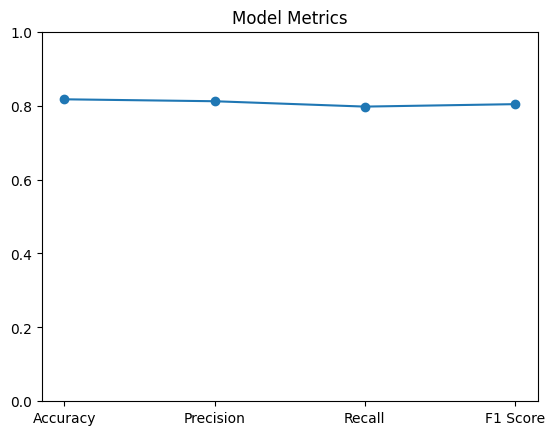

Accuracy: 0.8170434358563516
Precision: 0.811799854855203
Recall: 0.7973062386490556
F1 Score: 0.8039181873306818
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      7990
           1       0.83      0.73      0.78       872
           2       0.76      0.71      0.73      8194
           3       0.91      0.93      0.92     14430
           4       0.79      0.82      0.80      9930
           5       0.75      0.76      0.75      9660
           6       0.87      0.87      0.87      6342

    accuracy                           0.82     57418
   macro avg       0.81      0.80      0.80     57418
weighted avg       0.82      0.82      0.82     57418



100%|██████████| 90/90 [04:15<00:00,  2.84s/it]


Valid loss: 0.006695418618619442.	 Valid accuracy: 84.52%


100%|██████████| 898/898 [47:03<00:00,  3.14s/it]

Epoch 12
Train loss: 0.007473214337571569.	 Train accuracy: 82.30%


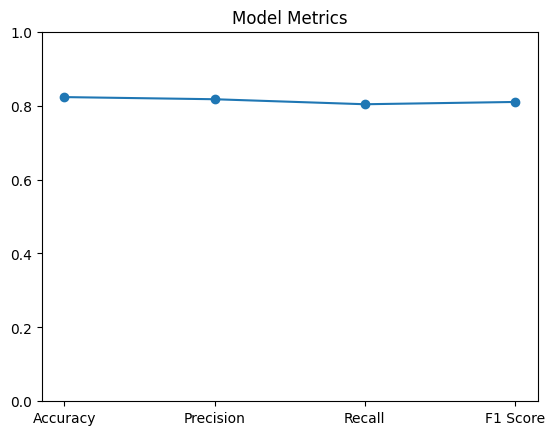

Accuracy: 0.8230171723153018
Precision: 0.8172159097915189
Recall: 0.8036562758370762
F1 Score: 0.8098655588343551
              precision    recall  f1-score   support

           0       0.79      0.76      0.78      7990
           1       0.83      0.74      0.78       872
           2       0.77      0.72      0.74      8194
           3       0.91      0.93      0.92     14430
           4       0.80      0.82      0.81      9930
           5       0.75      0.77      0.76      9660
           6       0.87      0.88      0.87      6342

    accuracy                           0.82     57418
   macro avg       0.82      0.80      0.81     57418
weighted avg       0.82      0.82      0.82     57418



100%|██████████| 90/90 [04:15<00:00,  2.84s/it]


Valid loss: 0.006767692044377327.	 Valid accuracy: 84.47%


100%|██████████| 898/898 [47:01<00:00,  3.14s/it]

Epoch 13
Train loss: 0.007266954742658807.	 Train accuracy: 82.94%


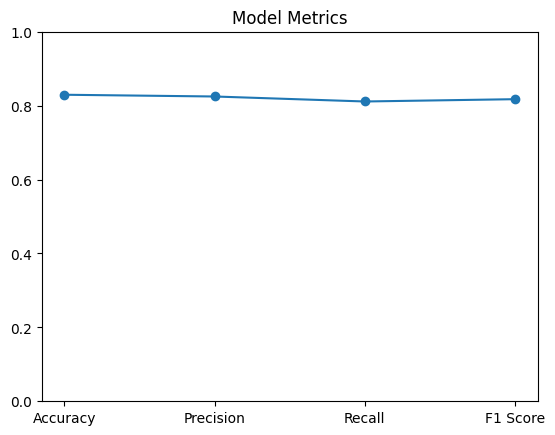

Accuracy: 0.8293740638824062
Precision: 0.8246358344627908
Recall: 0.811126369480386
F1 Score: 0.8173710727236875
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      7990
           1       0.84      0.75      0.80       872
           2       0.77      0.73      0.75      8194
           3       0.92      0.93      0.92     14430
           4       0.81      0.83      0.82      9930
           5       0.77      0.79      0.78      9660
           6       0.88      0.88      0.88      6342

    accuracy                           0.83     57418
   macro avg       0.82      0.81      0.82     57418
weighted avg       0.83      0.83      0.83     57418



100%|██████████| 90/90 [04:14<00:00,  2.83s/it]


Valid loss: 0.006541824899613857.	 Valid accuracy: 84.52%


100%|██████████| 898/898 [47:02<00:00,  3.14s/it]

Epoch 14
Train loss: 0.006976977121757736.	 Train accuracy: 83.49%


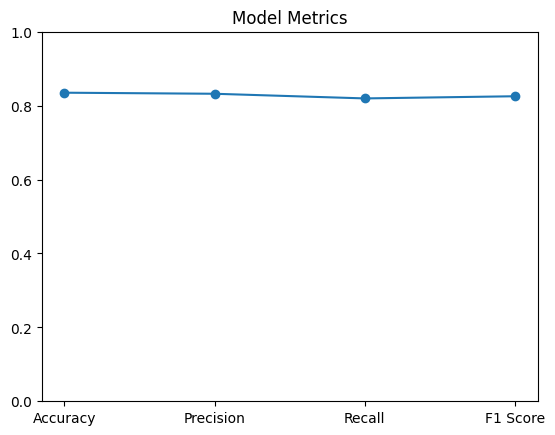

Accuracy: 0.8348949806680832
Precision: 0.8320328931538025
Recall: 0.8194299339526827
F1 Score: 0.8252973646138343
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      7990
           1       0.86      0.78      0.82       872
           2       0.78      0.74      0.76      8194
           3       0.92      0.93      0.93     14430
           4       0.81      0.83      0.82      9930
           5       0.77      0.79      0.78      9660
           6       0.88      0.88      0.88      6342

    accuracy                           0.83     57418
   macro avg       0.83      0.82      0.83     57418
weighted avg       0.83      0.83      0.83     57418



100%|██████████| 90/90 [04:15<00:00,  2.84s/it]


Valid loss: 0.006299504544585943.	 Valid accuracy: 85.35%


100%|██████████| 898/898 [46:58<00:00,  3.14s/it]

Epoch 15
Train loss: 0.006647290955903143.	 Train accuracy: 84.38%


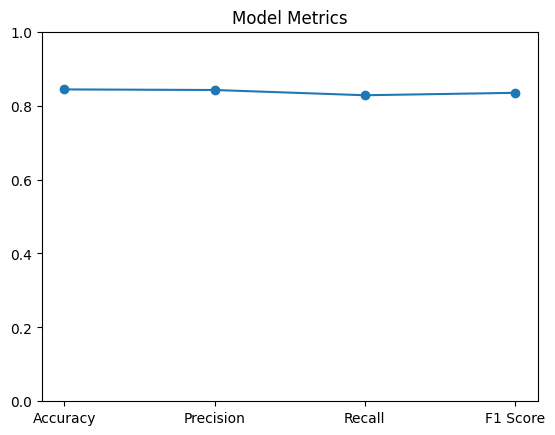

Accuracy: 0.8437772127207496
Precision: 0.8422043018869422
Recall: 0.828013982590537
F1 Score: 0.8345706176014056
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      7990
           1       0.88      0.78      0.83       872
           2       0.79      0.75      0.77      8194
           3       0.92      0.94      0.93     14430
           4       0.82      0.84      0.83      9930
           5       0.79      0.80      0.80      9660
           6       0.88      0.88      0.88      6342

    accuracy                           0.84     57418
   macro avg       0.84      0.83      0.83     57418
weighted avg       0.84      0.84      0.84     57418



100%|██████████| 90/90 [04:33<00:00,  3.04s/it]


Valid loss: 0.006189281120896339.	 Valid accuracy: 85.61%


100%|██████████| 898/898 [47:36<00:00,  3.18s/it]

Epoch 16
Train loss: 0.006530408427732243.	 Train accuracy: 84.52%


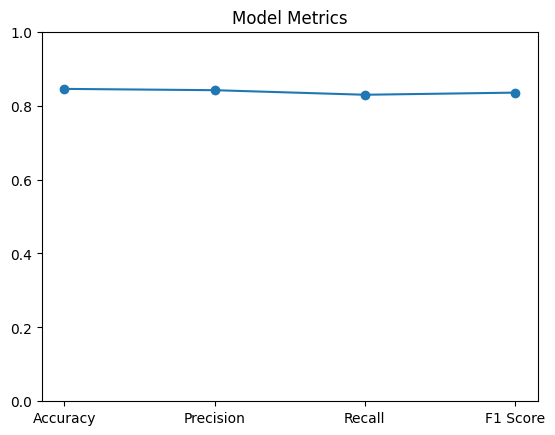

Accuracy: 0.8452227524469679
Precision: 0.8416856123085366
Recall: 0.8293343093378178
F1 Score: 0.8351088588406855
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      7990
           1       0.86      0.78      0.82       872
           2       0.79      0.75      0.77      8194
           3       0.92      0.94      0.93     14430
           4       0.82      0.85      0.83      9930
           5       0.78      0.80      0.79      9660
           6       0.89      0.88      0.88      6342

    accuracy                           0.85     57418
   macro avg       0.84      0.83      0.84     57418
weighted avg       0.84      0.85      0.84     57418



100%|██████████| 90/90 [04:15<00:00,  2.84s/it]


Valid loss: 0.006116614677011967.	 Valid accuracy: 85.58%


100%|██████████| 898/898 [47:35<00:00,  3.18s/it]

Epoch 17
Train loss: 0.006341093790340566.	 Train accuracy: 84.95%


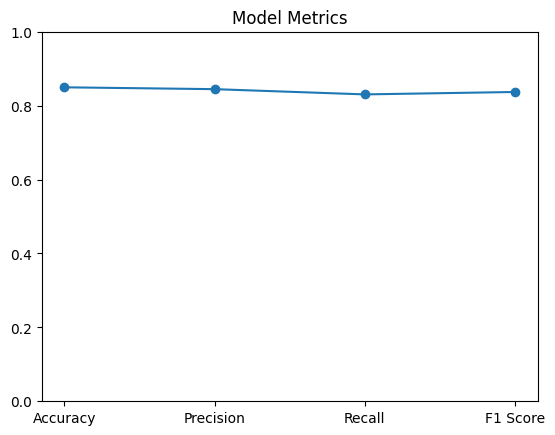

Accuracy: 0.8494897070605036
Precision: 0.8444836874792572
Recall: 0.8302941110826971
F1 Score: 0.8368691342626307
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      7990
           1       0.85      0.76      0.80       872
           2       0.80      0.76      0.78      8194
           3       0.93      0.94      0.93     14430
           4       0.83      0.85      0.84      9930
           5       0.79      0.81      0.80      9660
           6       0.89      0.89      0.89      6342

    accuracy                           0.85     57418
   macro avg       0.84      0.83      0.84     57418
weighted avg       0.85      0.85      0.85     57418



100%|██████████| 90/90 [04:15<00:00,  2.84s/it]


Valid loss: 0.00588239636272192.	 Valid accuracy: 86.42%


100%|██████████| 898/898 [49:29<00:00,  3.31s/it]

Epoch 18
Train loss: 0.006278206100907004.	 Train accuracy: 85.04%


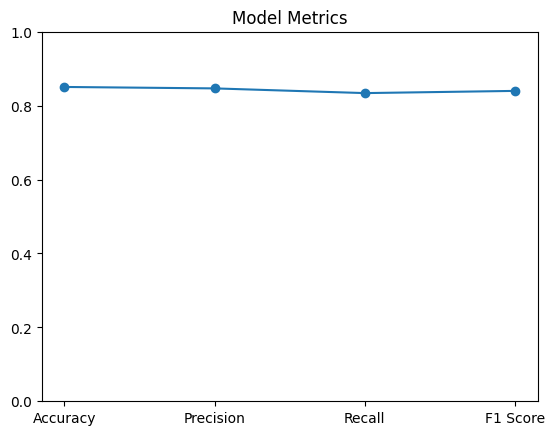

Accuracy: 0.8504301786896096
Precision: 0.846548331818663
Recall: 0.8338171133747884
F1 Score: 0.8397902868396319
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      7990
           1       0.86      0.78      0.82       872
           2       0.80      0.76      0.78      8194
           3       0.93      0.94      0.93     14430
           4       0.83      0.85      0.84      9930
           5       0.80      0.81      0.80      9660
           6       0.89      0.88      0.89      6342

    accuracy                           0.85     57418
   macro avg       0.85      0.83      0.84     57418
weighted avg       0.85      0.85      0.85     57418



100%|██████████| 90/90 [04:26<00:00,  2.96s/it]


Valid loss: 0.005631966516375542.	 Valid accuracy: 86.69%


100%|██████████| 898/898 [47:01<00:00,  3.14s/it]

Epoch 19
Train loss: 0.006119536526786392.	 Train accuracy: 85.65%


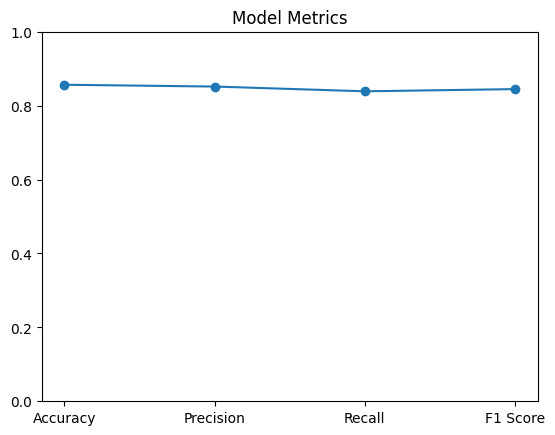

Accuracy: 0.856456163572399
Precision: 0.8515245668471275
Recall: 0.8386577789983987
F1 Score: 0.8446279941173065
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      7990
           1       0.86      0.77      0.81       872
           2       0.81      0.77      0.79      8194
           3       0.93      0.94      0.93     14430
           4       0.84      0.86      0.85      9930
           5       0.80      0.82      0.81      9660
           6       0.89      0.89      0.89      6342

    accuracy                           0.86     57418
   macro avg       0.85      0.84      0.84     57418
weighted avg       0.86      0.86      0.86     57418



100%|██████████| 90/90 [04:17<00:00,  2.86s/it]


Valid loss: 0.005560945253819227.	 Valid accuracy: 87.15%


100%|██████████| 898/898 [47:09<00:00,  3.15s/it]

Epoch 20
Train loss: 0.0060483557042845856.	 Train accuracy: 85.65%


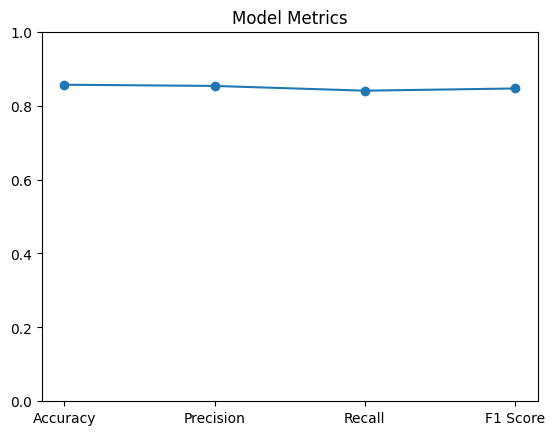

Accuracy: 0.8564735797136787
Precision: 0.8531999516834764
Recall: 0.8403376616463444
F1 Score: 0.8463293681158344
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      7990
           1       0.87      0.79      0.83       872
           2       0.81      0.77      0.79      8194
           3       0.93      0.94      0.94     14430
           4       0.84      0.86      0.85      9930
           5       0.80      0.82      0.81      9660
           6       0.89      0.90      0.89      6342

    accuracy                           0.86     57418
   macro avg       0.85      0.84      0.85     57418
weighted avg       0.86      0.86      0.86     57418



100%|██████████| 90/90 [04:16<00:00,  2.85s/it]


Valid loss: 0.0052985940128564835.	 Valid accuracy: 87.29%


100%|██████████| 898/898 [47:14<00:00,  3.16s/it]

Epoch 21
Train loss: 0.005986332009573741.	 Train accuracy: 85.96%


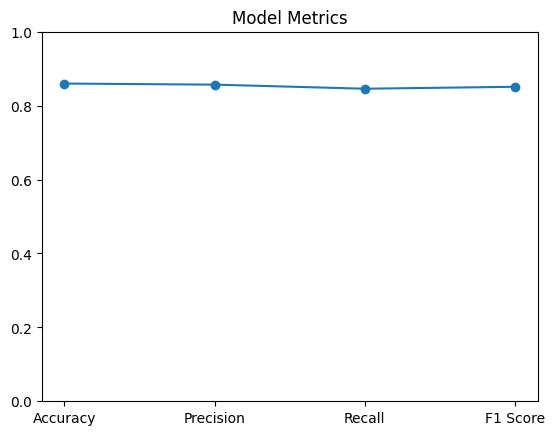

Accuracy: 0.8596259012853112
Precision: 0.8567334595453495
Recall: 0.8456721476012322
F1 Score: 0.8508897164406944
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      7990
           1       0.88      0.81      0.84       872
           2       0.82      0.78      0.80      8194
           3       0.93      0.94      0.94     14430
           4       0.84      0.86      0.85      9930
           5       0.81      0.82      0.81      9660
           6       0.89      0.89      0.89      6342

    accuracy                           0.86     57418
   macro avg       0.86      0.85      0.85     57418
weighted avg       0.86      0.86      0.86     57418



100%|██████████| 90/90 [04:13<00:00,  2.82s/it]


Valid loss: 0.005647415295243263.	 Valid accuracy: 87.01%


100%|██████████| 898/898 [46:30<00:00,  3.11s/it]

Epoch 22
Train loss: 0.005846280366750159.	 Train accuracy: 86.26%


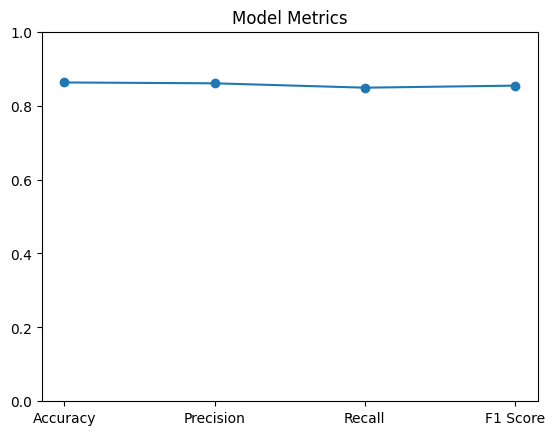

Accuracy: 0.8626040614441465
Precision: 0.86029463030472
Recall: 0.848499018455118
F1 Score: 0.8540506316151398
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      7990
           1       0.88      0.81      0.84       872
           2       0.81      0.78      0.80      8194
           3       0.93      0.94      0.94     14430
           4       0.85      0.86      0.86      9930
           5       0.81      0.83      0.82      9660
           6       0.90      0.90      0.90      6342

    accuracy                           0.86     57418
   macro avg       0.86      0.85      0.85     57418
weighted avg       0.86      0.86      0.86     57418



100%|██████████| 90/90 [04:06<00:00,  2.74s/it]


Valid loss: 0.0055194636806845665.	 Valid accuracy: 86.75%


100%|██████████| 898/898 [45:09<00:00,  3.02s/it]

Epoch 23
Train loss: 0.00569602058753187.	 Train accuracy: 86.50%


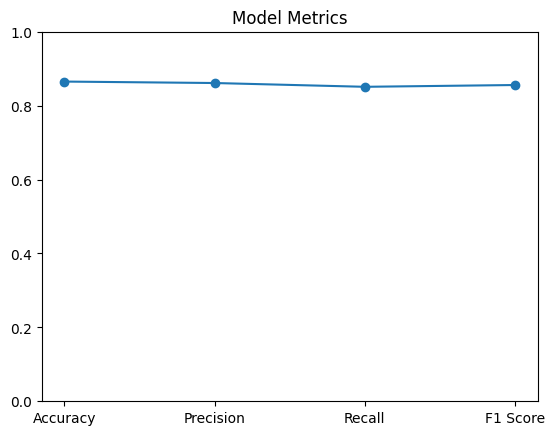

Accuracy: 0.86502490508203
Precision: 0.861088144624104
Recall: 0.8508516550239487
F1 Score: 0.8556881914003573
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      7990
           1       0.87      0.81      0.84       872
           2       0.82      0.78      0.80      8194
           3       0.93      0.94      0.94     14430
           4       0.85      0.87      0.86      9930
           5       0.82      0.83      0.82      9660
           6       0.90      0.90      0.90      6342

    accuracy                           0.87     57418
   macro avg       0.86      0.85      0.86     57418
weighted avg       0.86      0.87      0.86     57418



100%|██████████| 90/90 [04:04<00:00,  2.72s/it]


Valid loss: 0.005589180625975132.	 Valid accuracy: 87.16%


100%|██████████| 898/898 [45:05<00:00,  3.01s/it]

Epoch 24
Train loss: 0.005603068236457155.	 Train accuracy: 86.71%


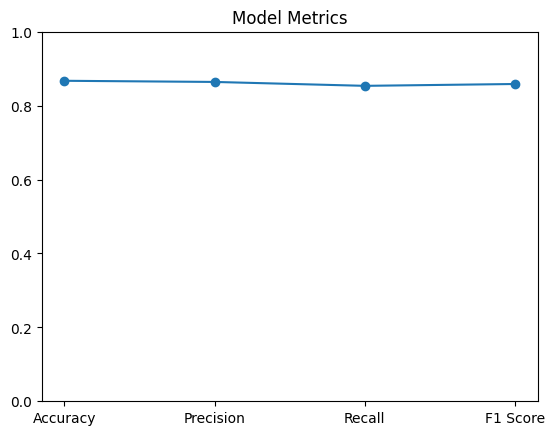

Accuracy: 0.8671322581768783
Precision: 0.8640172781172962
Recall: 0.8534494267504856
F1 Score: 0.8584519463153099
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      7990
           1       0.88      0.81      0.84       872
           2       0.82      0.79      0.81      8194
           3       0.93      0.95      0.94     14430
           4       0.85      0.86      0.86      9930
           5       0.82      0.83      0.83      9660
           6       0.90      0.90      0.90      6342

    accuracy                           0.87     57418
   macro avg       0.86      0.85      0.86     57418
weighted avg       0.87      0.87      0.87     57418



100%|██████████| 90/90 [04:04<00:00,  2.72s/it]


Valid loss: 0.0053086671978235245.	 Valid accuracy: 87.50%


100%|██████████| 898/898 [45:05<00:00,  3.01s/it]

Epoch 25
Train loss: 0.0055775979285365325.	 Train accuracy: 86.89%


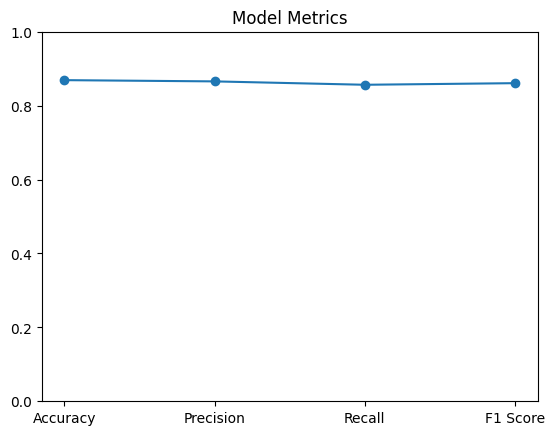

Accuracy: 0.8688738723048521
Precision: 0.8655028735824557
Recall: 0.8563457676095944
F1 Score: 0.8606894481607049
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      7990
           1       0.88      0.82      0.85       872
           2       0.83      0.79      0.81      8194
           3       0.94      0.95      0.94     14430
           4       0.85      0.86      0.86      9930
           5       0.82      0.84      0.83      9660
           6       0.90      0.90      0.90      6342

    accuracy                           0.87     57418
   macro avg       0.87      0.86      0.86     57418
weighted avg       0.87      0.87      0.87     57418



100%|██████████| 90/90 [04:05<00:00,  2.72s/it]


Valid loss: 0.00495191989466548.	 Valid accuracy: 88.45%


100%|██████████| 898/898 [45:07<00:00,  3.01s/it]

Epoch 26
Train loss: 0.005486879912221098.	 Train accuracy: 87.09%


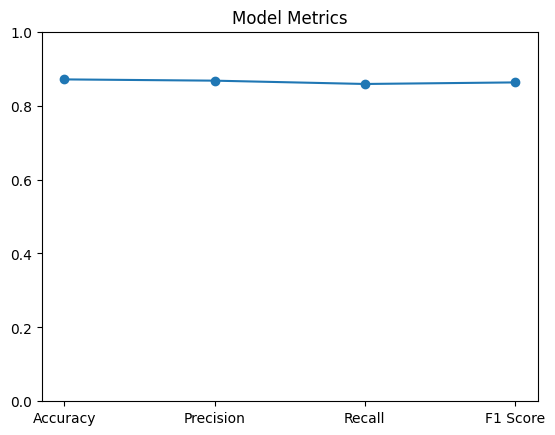

Accuracy: 0.8708941446933017
Precision: 0.8674688412434014
Recall: 0.8585002729117386
F1 Score: 0.8627463085311218
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      7990
           1       0.88      0.82      0.85       872
           2       0.83      0.79      0.81      8194
           3       0.94      0.95      0.94     14430
           4       0.85      0.87      0.86      9930
           5       0.82      0.84      0.83      9660
           6       0.90      0.90      0.90      6342

    accuracy                           0.87     57418
   macro avg       0.87      0.86      0.86     57418
weighted avg       0.87      0.87      0.87     57418



100%|██████████| 90/90 [04:05<00:00,  2.73s/it]


Valid loss: 0.005438307765871286.	 Valid accuracy: 87.13%


100%|██████████| 898/898 [46:10<00:00,  3.08s/it]

Epoch 27
Train loss: 0.005332375222645715.	 Train accuracy: 87.59%


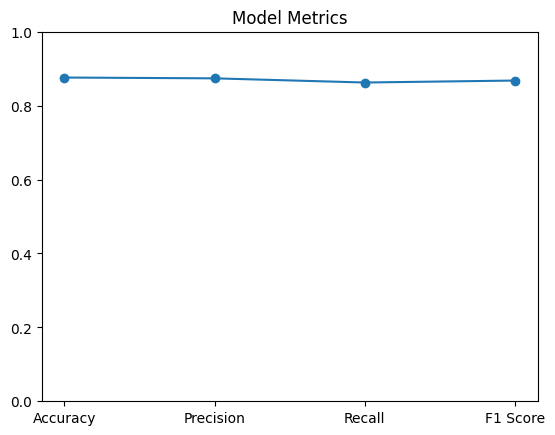

Accuracy: 0.8759274095231461
Precision: 0.8737417763896687
Recall: 0.8624698494898257
F1 Score: 0.8677731083691137
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      7990
           1       0.89      0.82      0.86       872
           2       0.84      0.80      0.82      8194
           3       0.94      0.95      0.94     14430
           4       0.86      0.87      0.87      9930
           5       0.83      0.85      0.84      9660
           6       0.90      0.91      0.91      6342

    accuracy                           0.88     57418
   macro avg       0.87      0.86      0.87     57418
weighted avg       0.88      0.88      0.88     57418



100%|██████████| 90/90 [04:10<00:00,  2.79s/it]


Valid loss: 0.004659737925976515.	 Valid accuracy: 88.58%


100%|██████████| 898/898 [45:43<00:00,  3.06s/it]

Epoch 28
Train loss: 0.005339118263056595.	 Train accuracy: 87.49%


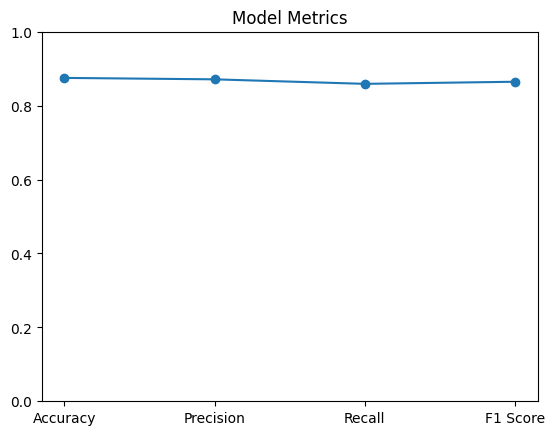

Accuracy: 0.874934689470201
Precision: 0.8710555112966408
Recall: 0.8588294242330148
F1 Score: 0.8645528065167737
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      7990
           1       0.88      0.80      0.84       872
           2       0.84      0.80      0.82      8194
           3       0.94      0.95      0.94     14430
           4       0.86      0.88      0.87      9930
           5       0.83      0.84      0.83      9660
           6       0.90      0.91      0.91      6342

    accuracy                           0.87     57418
   macro avg       0.87      0.86      0.86     57418
weighted avg       0.87      0.87      0.87     57418



100%|██████████| 90/90 [04:23<00:00,  2.92s/it]


Valid loss: 0.004800464492291212.	 Valid accuracy: 88.65%


100%|██████████| 898/898 [44:28<00:00,  2.97s/it]


Epoch 29
Train loss: 0.005209754036914061.	 Train accuracy: 87.89%


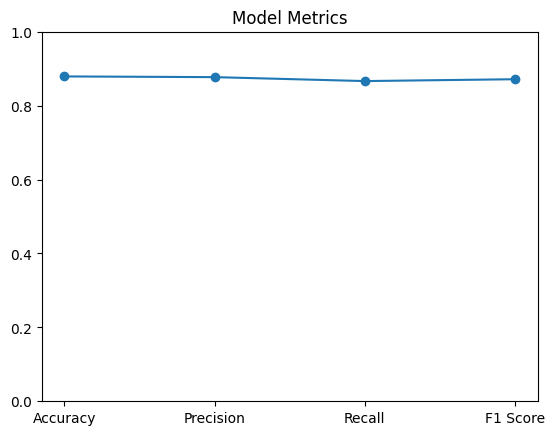

Accuracy: 0.878922985823261
Precision: 0.8770144314298253
Recall: 0.8663400822488391
F1 Score: 0.8713709526612057
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      7990
           1       0.90      0.83      0.86       872
           2       0.84      0.80      0.82      8194
           3       0.94      0.95      0.94     14430
           4       0.87      0.88      0.87      9930
           5       0.83      0.85      0.84      9660
           6       0.90      0.91      0.91      6342

    accuracy                           0.88     57418
   macro avg       0.88      0.87      0.87     57418
weighted avg       0.88      0.88      0.88     57418



100%|██████████| 90/90 [03:58<00:00,  2.65s/it]


Valid loss: 0.0045090909115970135.	 Valid accuracy: 89.22%


100%|██████████| 898/898 [45:35<00:00,  3.05s/it]


Epoch 30
Train loss: 0.005217279692056631.	 Train accuracy: 87.74%


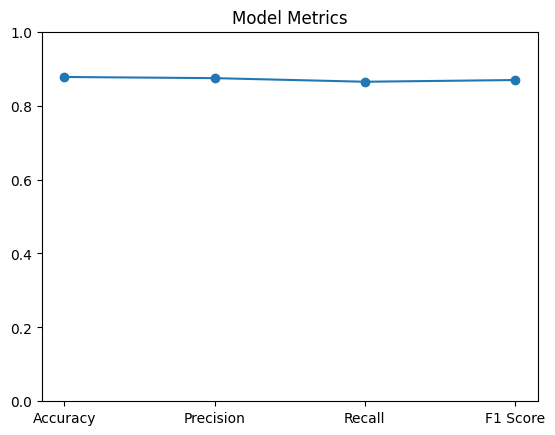

Accuracy: 0.8774251976732035
Precision: 0.8743003554116479
Recall: 0.8645344107932688
F1 Score: 0.8691673938441988
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      7990
           1       0.89      0.82      0.85       872
           2       0.84      0.80      0.82      8194
           3       0.94      0.95      0.95     14430
           4       0.86      0.87      0.87      9930
           5       0.83      0.84      0.84      9660
           6       0.91      0.91      0.91      6342

    accuracy                           0.88     57418
   macro avg       0.87      0.86      0.87     57418
weighted avg       0.88      0.88      0.88     57418



100%|██████████| 90/90 [04:33<00:00,  3.03s/it]


Valid loss: 0.004608038812875748.	 Valid accuracy: 89.20%


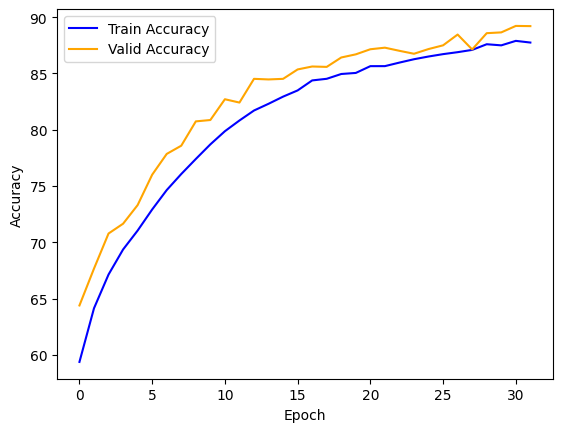

In [24]:
#vit = torch.load("model.pth")
start_epoch, train_accs, valid_accs = load_checkpoint(model, optimizer, "checkpoint.pth")
ViT_train(model, optimizer, start_epoch, train_accs, valid_accs)

100%|██████████| 113/113 [05:19<00:00,  2.83s/it]


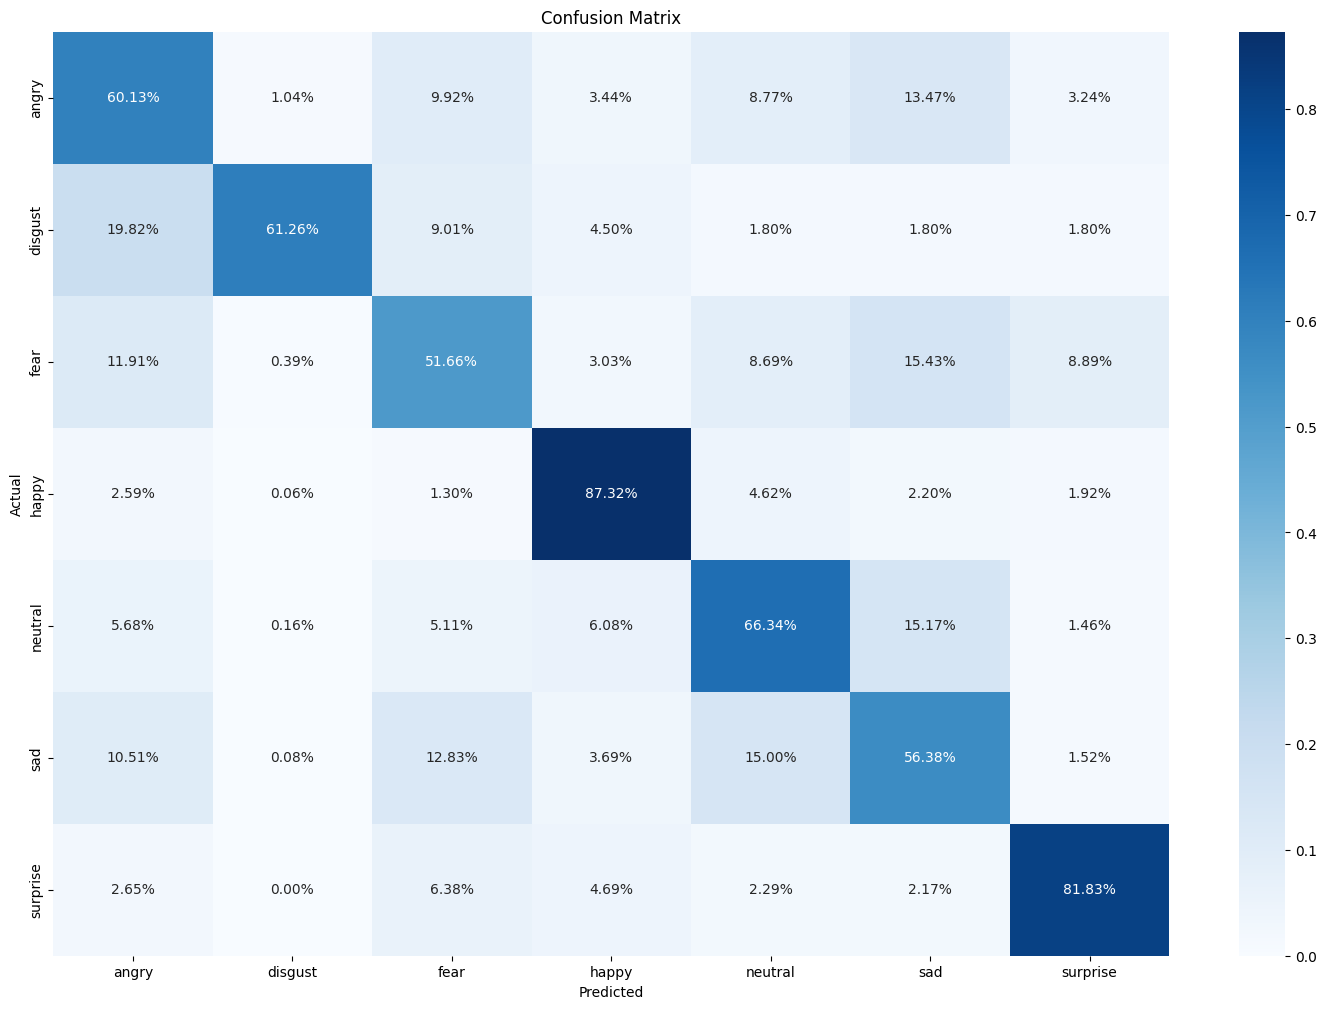

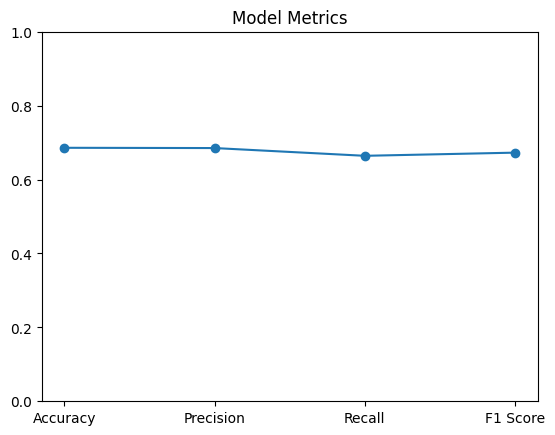

Accuracy: 0.6858456394538869
Precision: 0.6851103801538506
Recall: 0.6641573622760425
F1 Score: 0.6727193709711147
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       958
           1       0.79      0.61      0.69       111
           2       0.57      0.52      0.54      1024
           3       0.87      0.87      0.87      1774
           4       0.64      0.66      0.65      1233
           5       0.57      0.56      0.57      1247
           6       0.78      0.82      0.80       831

    accuracy                           0.69      7178
   macro avg       0.69      0.66      0.67      7178
weighted avg       0.68      0.69      0.68      7178



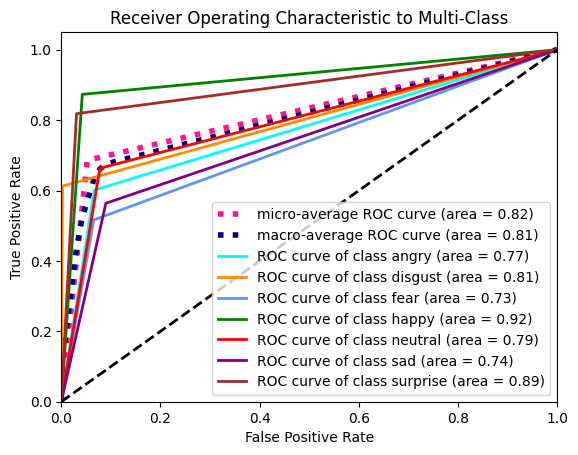

(68.5845639453887, tensor(0.0246, device='cuda:0'))

In [26]:
#vit = torch.load("model.pth")
In_testing = True
ViT_test(vit, test_loader)

In [ ]:
torch.save(vit.state_dict(), "ViT_params.pth")

#vit.load_state_dict(torch.load("model_params.pth"))

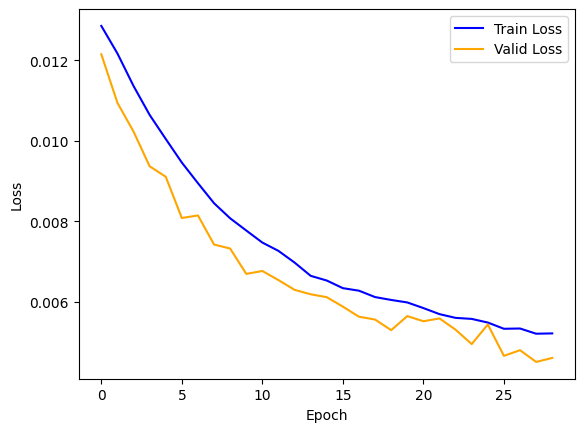

In [27]:
train_loss = [0.012854494266825753
    ,0.012170774678234903
    ,0.01136281951940638
    ,0.010644838855455835
    ,0.010047157330570137
    ,0.009460423814006358
    ,0.008948537843421466
    ,0.008451000804802962
    ,0.008076326666148945
    ,0.007773143294305279
    ,0.007473214337571569
    ,0.007266954742658807
    ,0.006976977121757736
    ,0.006647290955903143
    ,0.006530408427732243
    ,0.006341093790340566
    ,0.006278206100907004
    ,0.006119536526786392
    ,0.0060483557042845856
    ,0.005986332009573741
    ,0.005846280366750159
    ,0.00569602058753187
    ,0.005603068236457155
    ,0.0055775979285365325
    ,0.005486879912221098
    ,0.005332375222645715
    ,0.005339118263056595
    ,0.005209754036914061
    ,0.005217279692056631]

valid_loss = [0.012149583548307419
    ,0.010944444686174393
    ,0.010230963118374348
    ,0.00936884991824627
    ,0.009108091704547405
    ,0.00808359682559967
    ,0.008147528395056725
    ,0.007424929179251194
    ,0.007325185928493738
    ,0.006695418618619442
    ,0.006767692044377327
    ,0.006541824899613857
    ,0.006299504544585943
    ,0.006189281120896339
    ,0.006116614677011967
    ,0.00588239636272192
    ,0.005631966516375542
    ,0.005560945253819227
    ,0.0052985940128564835
    ,0.005647415295243263
    ,0.0055194636806845665
    ,0.005589180625975132
    ,0.0053086671978235245
    ,0.00495191989466548
    ,0.005438307765871286
    ,0.004659737925976515
    ,0.004800464492291212
    ,0.0045090909115970135
    ,0.004608038812875748]

plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(valid_loss, label='Valid Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()